In [32]:
import glob
import os
import tempfile
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime
from datetime import timedelta

from math import atan2 as atan2
from datetime import datetime

from metpy.plots import USCOUNTIES
from metpy.calc import dewpoint_from_relative_humidity
from metpy.units import units
from matplotlib.dates import DateFormatter, date2num
import imageio
import pyart
import nexradaws

import sage_data_client

templocation = tempfile.mkdtemp()

import os

import matplotlib.pyplot as plt

import act

import math

warnings.filterwarnings("ignore")

In [50]:
## NEIU AQT 
df_aq = sage_data_client.query(start = "2023-06-26" + 'T' + "00:00:00" + 'Z',
                               end = "2023-06-29" + 'T' + "12:00:00" + 'Z', 
                               filter={
                                        "plugin": "registry.sagecontinuum.org/jrobrien/waggle-aqt:0.23.5.*",
                                       }
)
# extract the particle measurements from the DataFrame
pm25 = df_aq[df_aq['name']=='aqt.particle.pm2.5']
pm10 = df_aq[df_aq['name']=='aqt.particle.pm1']
pm100 = df_aq[df_aq['name']=='aqt.particle.pm10']

# extract the gas measurements from the DataFrame
no = df_aq[df_aq['name']=='aqt.gas.no']
o3 = df_aq[df_aq['name']=='aqt.gas.ozone']
no2 = df_aq[df_aq['name']=='aqt.gas.no2']
co = df_aq[df_aq['name']=='aqt.gas.co']

# extract the environment data from the DataFrame
aqtemp = df_aq[df_aq['name']=='aqt.env.temp']
aqhum = df_aq[df_aq['name']=='aqt.env.humidity']

# Convert values to numpy arrays
aqvals = pm25.set_index('timestamp')
aqvals['pm2.5'] = aqvals.value.to_numpy().astype(float)
aqvals['pm1.0'] = pm10.value.to_numpy().astype(float)
aqvals['pm10.0'] = pm100.value.to_numpy().astype(float)
aqvals['no'] = no.value.to_numpy().astype(float)
aqvals['o3'] = o3.value.to_numpy().astype(float)
aqvals['no2'] = no2.value.to_numpy().astype(float)
aqvals['co'] = co.value.to_numpy().astype(float)
aqvals['temp'] =  aqtemp.value.to_numpy().astype(float)
aqvals['hum'] =  aqhum.value.to_numpy().astype(float)

# Use MetPY to calculate dewpoint from temperature and relative humidity
dp = dewpoint_from_relative_humidity( aqvals.temp.to_numpy() * units.degC, 
                                     aqvals.hum.to_numpy() * units.percent)

aqvals['dewpoint'] = dp

In [22]:
time_window = [datetime(2023, 6, 26, 0, 0), datetime(2023, 6, 29, 12, 0)]
my_asoses = act.discovery.get_asos(time_window, station="ORD")

Downloading: ORD


In [135]:
my_asoses["ORD"]
u = np.array(my_asoses["ORD"].u)
v = np.array(my_asoses["ORD"].v)
wind_speed = np.sqrt(u**2 + v**2)
wind_direction = []
for i in range(len(u)):
    wind_direction.append((270-atan2(u[i],v[i])*180/np.pi) % 360) 

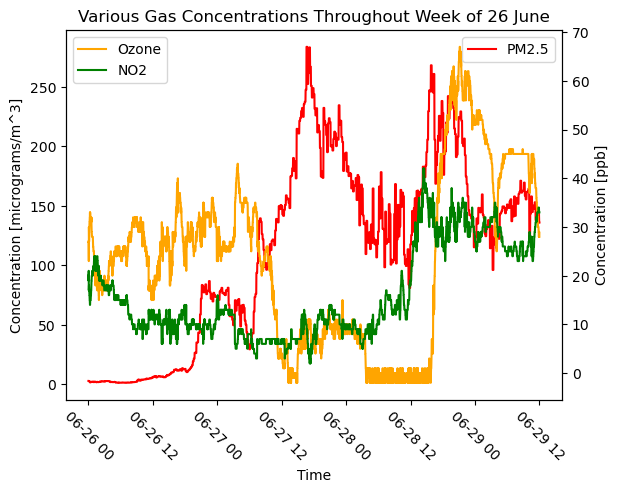

In [12]:
## Making graphs of various gas concentrations
fig, ax1 = plt.subplots()
plt.plot(pm25["timestamp"], pm25["value"], color="Red", label="PM2.5")
plt.xticks(rotation=315)
plt.xlabel("Time")
plt.ylabel("Concentration [micrograms/m^3]")
plt.legend()
plt.title("Various Gas Concentrations Throughout Week of 26 June")

ax2 = ax1.twinx()
ax2.plot(o3["timestamp"], o3["value"]*1000, color="Orange", label="Ozone")
ax2.plot(no["timestamp"], no2["value"]*1000, color="Green", label="NO2")
plt.ylabel("Concentration [ppb]")
plt.legend()

Text(0, 0.5, 'Wind Speed (kts)')

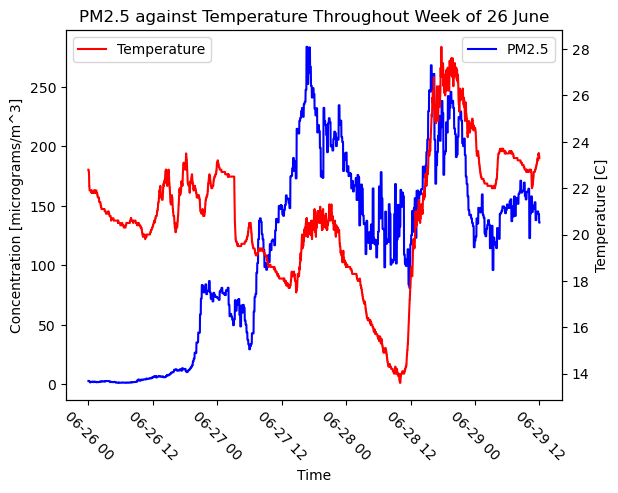

<Figure size 640x480 with 0 Axes>

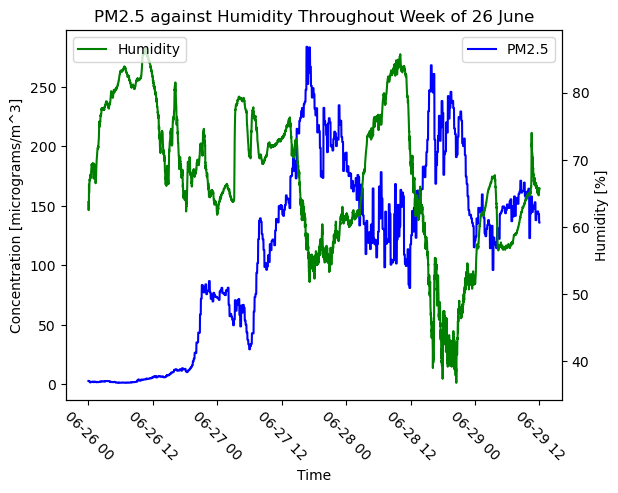

<Figure size 640x480 with 0 Axes>

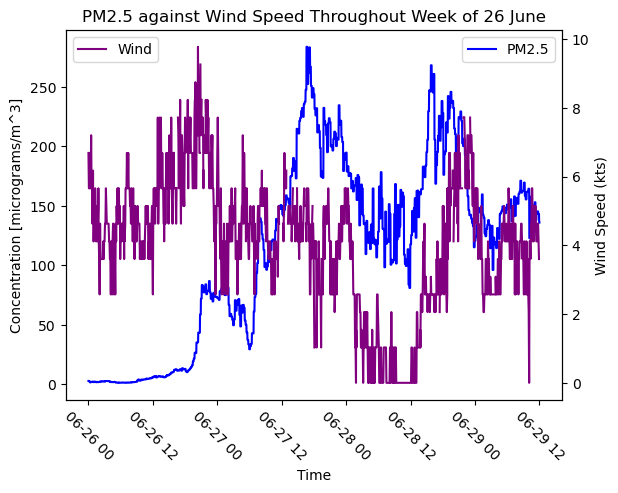

In [94]:
## Making cocnentrations of PM2.5 against various values

fig, ax1 = plt.subplots()
plt.plot(pm25["timestamp"], pm25["value"], color="Blue", label="PM2.5")
plt.xticks(rotation=315)
plt.xlabel("Time")
plt.ylabel("Concentration [micrograms/m^3]")
plt.legend()
plt.title("PM2.5 against Temperature Throughout Week of 26 June")

ax2 = ax1.twinx()
plt.plot(aqtemp["timestamp"], aqtemp["value"], color="Red", label="Temperature")
plt.legend()
plt.ylabel("Temperature [C]")

plt.figure()
fig, ax1 = plt.subplots()
plt.plot(pm25["timestamp"], pm25["value"], color="Blue", label="PM2.5")
plt.xticks(rotation=315)
plt.xlabel("Time")
plt.ylabel("Concentration [micrograms/m^3]")
plt.legend()
plt.title("PM2.5 against Humidity Throughout Week of 26 June")

ax2 = ax1.twinx()
plt.plot(aqhum["timestamp"], aqhum["value"], color="Green", label="Humidity")
plt.legend(loc=2)
plt.ylabel("Humidity [%]")

plt.figure()
fig, ax1 = plt.subplots()
plt.plot(pm25["timestamp"], pm25["value"], color="Blue", label="PM2.5")
plt.xticks(rotation=315)
plt.xlabel("Time")
plt.ylabel("Concentration [micrograms/m^3]")
plt.legend()
plt.title("PM2.5 against Wind Speed Throughout Week of 26 June")

ax2 = ax1.twinx()
plt.plot(my_asoses["ORD"].time, wind_speed, color="Purple", label="Wind")
plt.legend(loc=2)
plt.ylabel("Wind Speed (kts)")

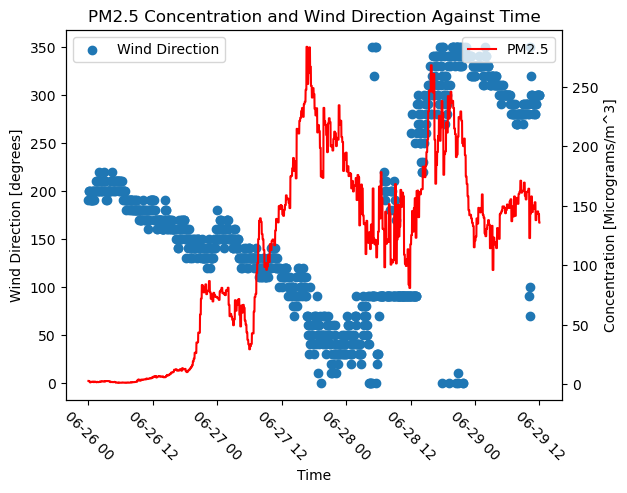

In [145]:
## Making a scatterplot of wind direction and PM2.5 Concentration 

real_pm25 = []
counter = 0
time_array_1 = np.array(pm25["timestamp"])
pm_25 = np.array(pm25["value"])
time_array_2 = my_asoses["ORD"].time.values
for j in range(len(time_array_2)):
    time1 = np.datetime64(time_array_2[j])
    while True:
        time2 = np.datetime64(time_array_1[counter])
        if (time1 <= time2):
            real_pm25.append(pm_25[counter])
            break
        else:
            counter += 1

fig, ax1 = plt.subplots()
plt.scatter(time_array_2, wind_direction, label="Wind Direction")
plt.xticks(rotation=315)
plt.xlabel("Time")
plt.ylabel("Wind Direction [degrees]")
plt.title("PM2.5 Concentration and Wind Direction Against Time")
plt.legend()

ax2 = ax1.twinx()
plt.plot(pm25["timestamp"], pm25["value"], color="Red", label="PM2.5")
plt.ylabel("Concentration [Micrograms/m^3]")
plt.legend()

In [129]:
pm_25[counter]

array([2.9, 2.9, 2.9, ..., 135.9, 135.9, 135.9], dtype=object)

In [119]:
time_array_1

55440   2023-06-26 00:00:03.507959035+00:00
55441   2023-06-26 00:01:03.555953661+00:00
55442   2023-06-26 00:02:03.598853979+00:00
55443   2023-06-26 00:03:03.644186003+00:00
55444   2023-06-26 00:04:03.677896907+00:00
                        ...                
60475   2023-06-29 11:55:03.505836398+00:00
60476   2023-06-29 11:56:03.551589318+00:00
60477   2023-06-29 11:57:03.598294481+00:00
60478   2023-06-29 11:58:03.642974804+00:00
60479   2023-06-29 11:59:03.676880747+00:00
Name: timestamp, Length: 5040, dtype: datetime64[ns, UTC]

In [98]:
len(time_array)

1115

In [113]:
real_pm25

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
